# Part 0: Startup

In [4]:
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
import pytz
from tqdm import tqdm
from decimal import Decimal


In [18]:
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as pe

format_k = lambda x, pos: f'{x/10**3:,.0f}K'
plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')
import warnings
# 忽略 pandas 警告
warnings.filterwarnings('ignore')
from matplotlib import font_manager

font_dirs = ['./Fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)



# Part I Total Reward Sum by Daily

In [20]:
# Read in Transaction Data
# data = pd.read_csv('total_reward_sum_by_daily.csv')
import pandas as pd
def read_large_csv(file_path, chunk_size=1000000):
    accumulated_data = pd.DataFrame()
    chunks = pd.read_csv(file_path, chunksize=chunk_size)
    for chunk in chunks:
        accumulated_data = pd.concat([accumulated_data, chunk])
    return accumulated_data
data=read_large_csv('../data/total_reward_sum_daily.csv')
data.head()

,date,final_total_reward,proposer_total_reward,attestation_total_reward,sync_total_reward
0,2022-09-15,1142336453893,147823762714,960736468121,33776223058
1,2022-09-16,1590103889535,205197949000,1336935154055,47970786480
2,2022-09-17,1609976379528,206454113667,1354427393059,49094872802
3,2022-09-18,1620454747426,207083260113,1363916989995,49454497318
4,2022-09-19,1626254416652,207451069783,1369820615547,48982731322


In [10]:
data=data.sort_values(by='date') # sort by date
#Convert Gwei to Ether
data=data.set_index('date')
data=data/Decimal(10**9)
data=data.reset_index()
df=data.copy()
df=df.iloc[1:-1] # cut the first day and last day
df.rename(columns={'final_total_reward':'Total reward','proposer_total_reward':'Proposer reward','attestation_total_reward':'Attestation reward','sync_total_reward':'Sync committee reward'
                   },inplace=True)# Get columns that end with '_reward'
df['date']=pd.to_datetime(df['date'])

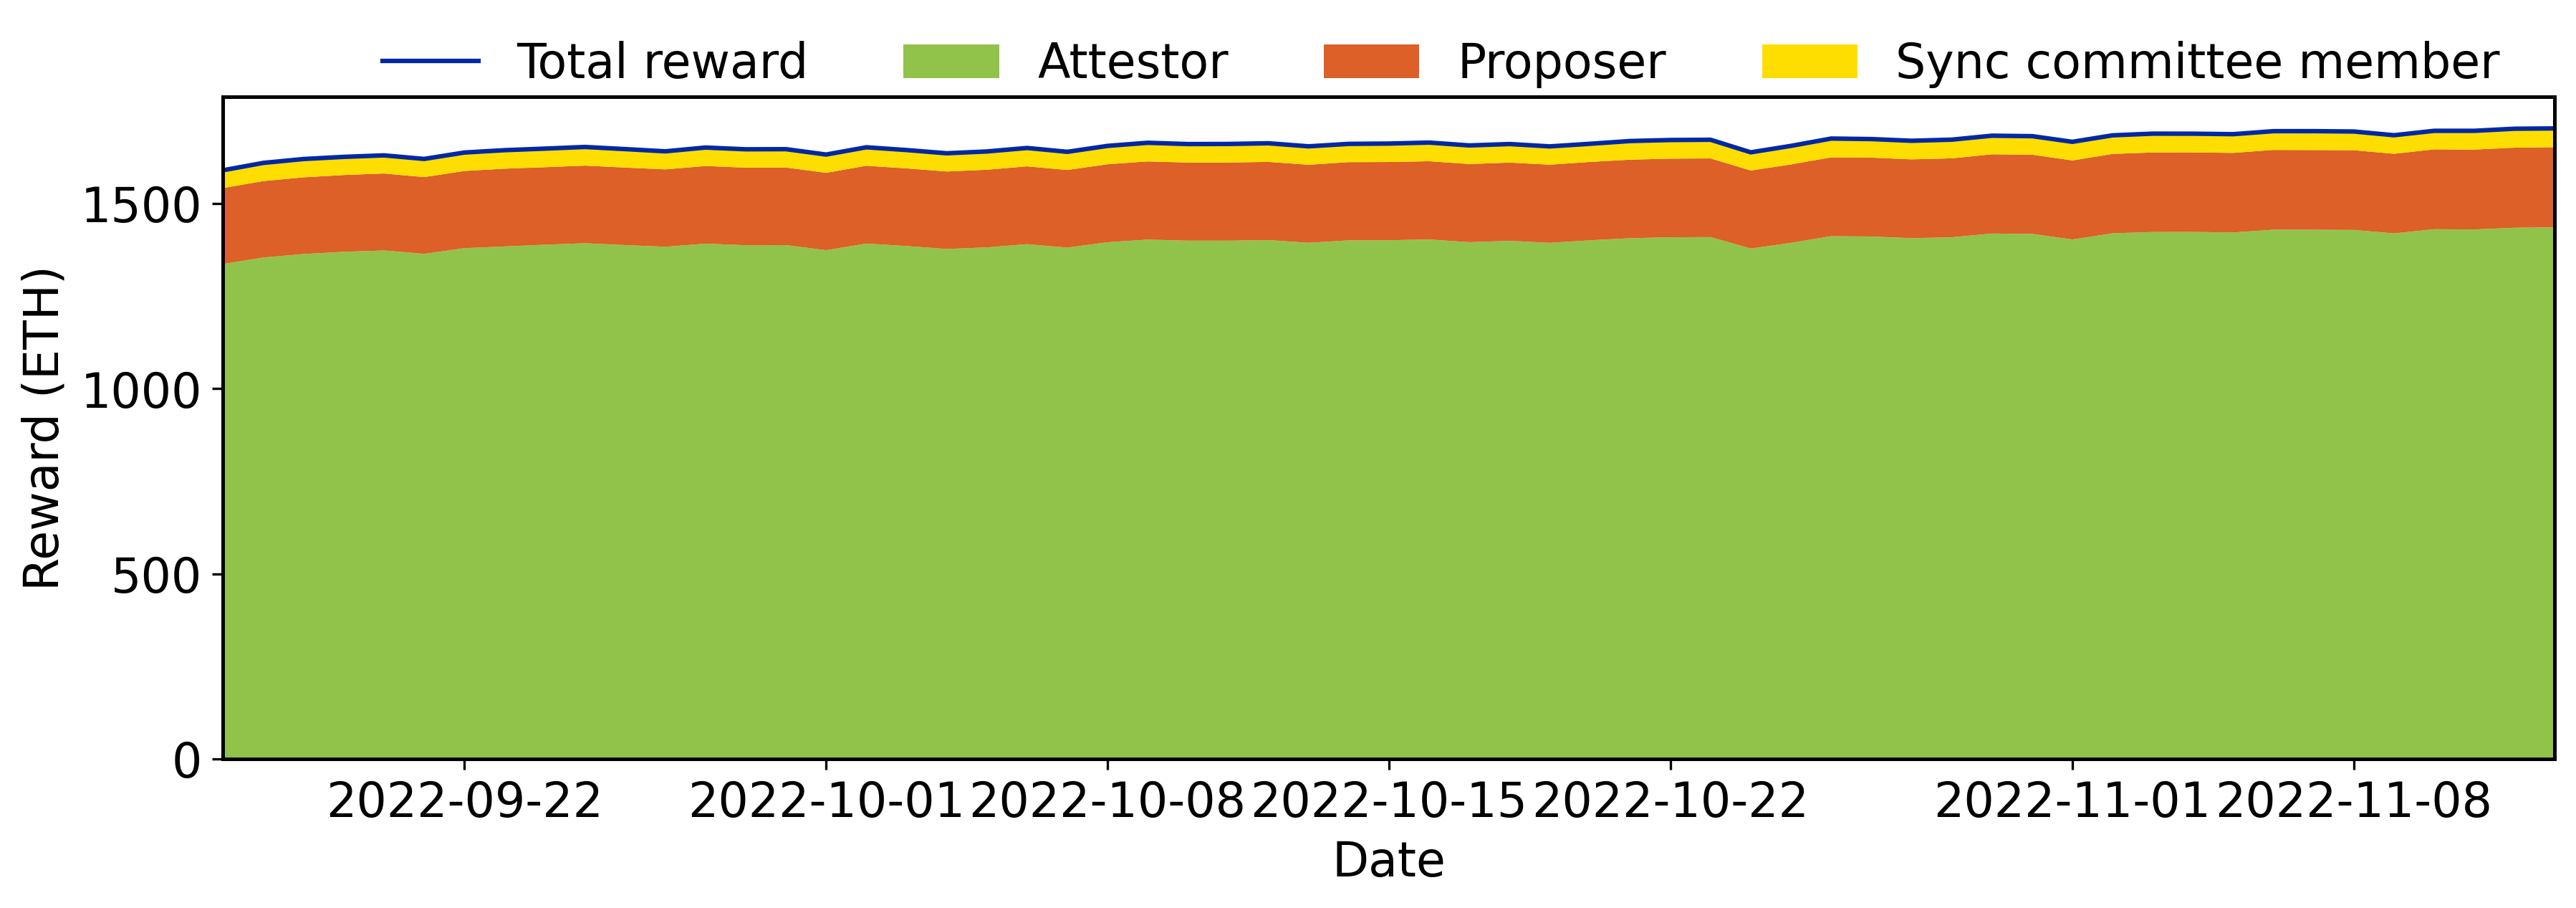

In [22]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=300)
ax.plot(df['date'], df['Total reward'], label='Total reward',linewidth=1.5)
ax.stackplot(df['date'], df['Attestation reward'], df['Proposer reward'], df['Sync committee reward'], labels=['Attestor', 'Proposer', 'Sync committee member'],colors=['#91c34a', '#dc6027', '#fede00'])
ax.set_xlabel('Date',fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel('Reward (ETH)',fontsize=16)
ax.legend(fontsize=16)
# ax.set_title('Daily reward',fontsize=14)
ax.set_xlim(left=df['date'].iloc[0])
ax.set_xlim(right=df['date'].iloc[-1])
ax.legend(loc='upper left',fontsize=16,ncol=4,bbox_to_anchor=(0.05,1.15),frameon=False)
# ax.set_ylim(bottom=0)
plt.savefig('../figure/total_reward_daily.pdf',bbox_inches='tight',dpi=300,facecolor='white')

## daily reward value distribution

Intuitive impression: how many Ether per day for each type of reward. 

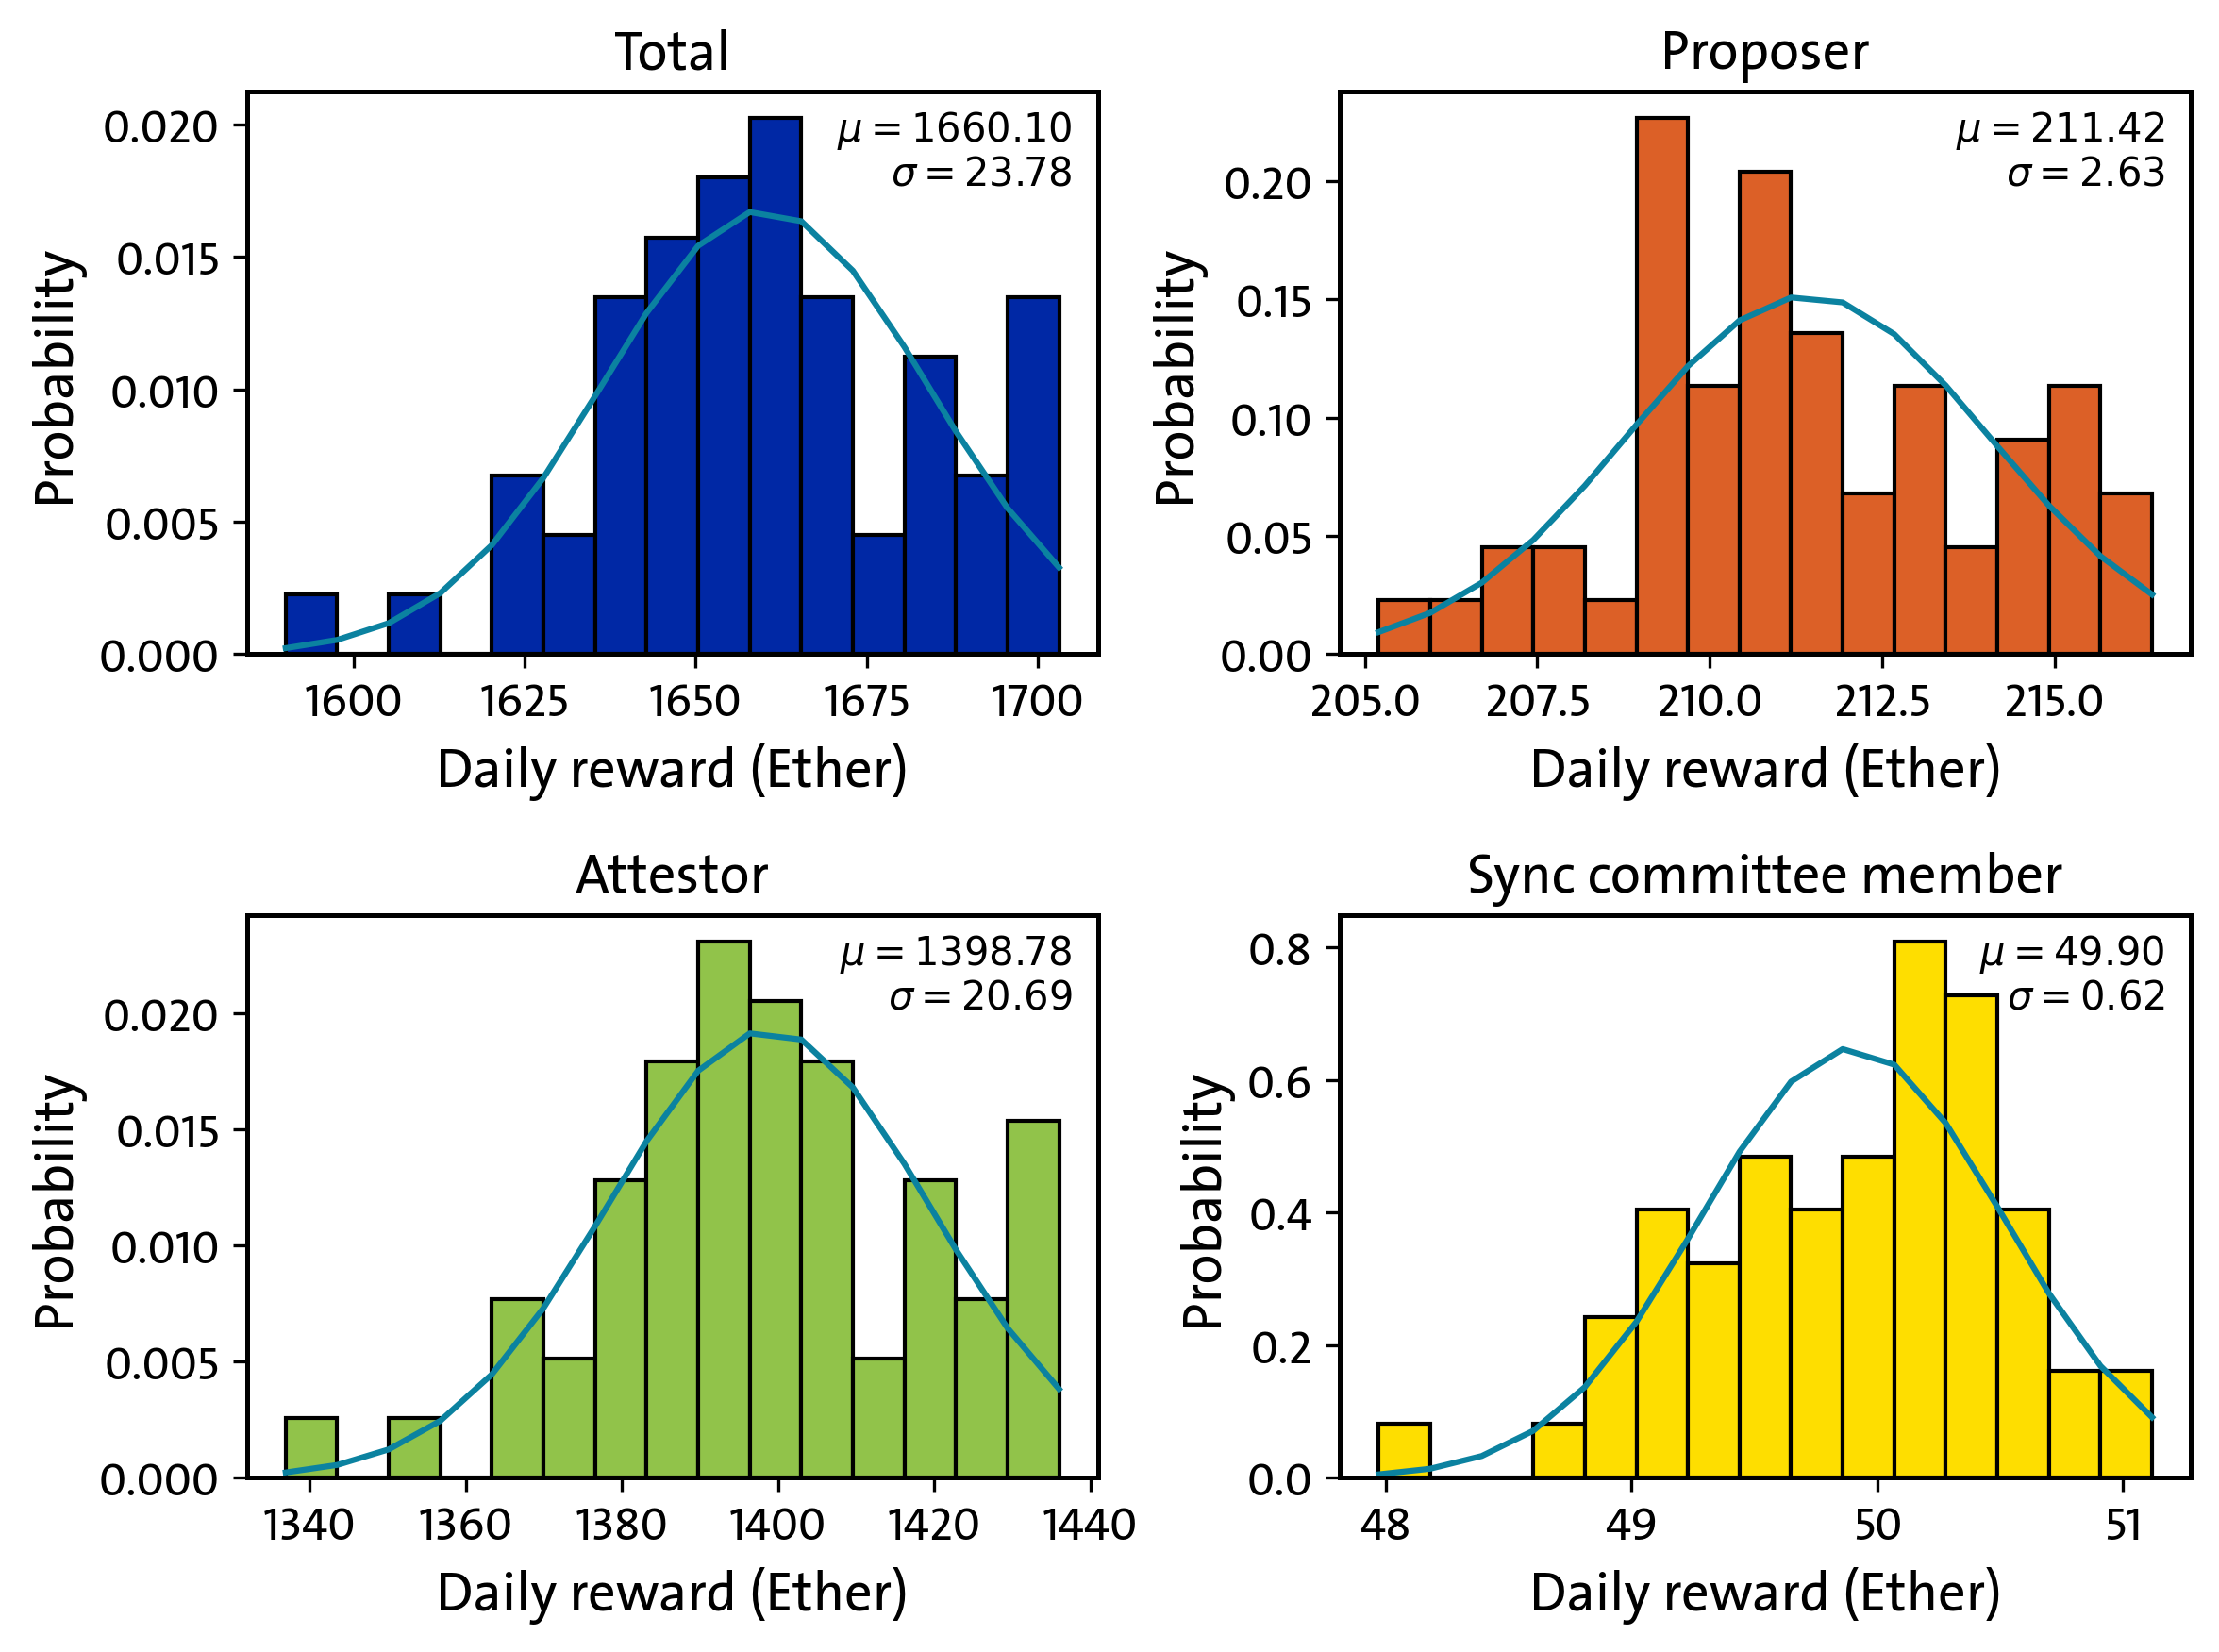

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

columns_to_plot = df.columns[1:5]
colors = ['#0028a5', '#dc6027', '#91c34a', '#fede00']

# Define subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Flatten the 2x2 array of axes for easier indexing
axes = axes.flatten()

# Add histograms to each subplot column
for i, column in enumerate(columns_to_plot):
    x = df[column].apply(float)
    mu = x.mean()
    sigma = x.values.std()
    num_bins = 15
    n, bins, patches = axes[i].hist(x, num_bins, density=1, edgecolor='black', color=colors[i])
    y = stats.norm.pdf(bins, mu, sigma)
    axes[i].plot(bins, y, color='#0b82a0', linewidth=1.5)
    axes[i].text(0.97, 0.97, f'$\mu={mu:.2f}$\n$\sigma={sigma:.2f}$', verticalalignment='top',
                 horizontalalignment='right', transform=axes[i].transAxes, fontsize=10)
    # axes[i].legend(loc='upper right', fontsize=14)
    if column == 'Sync committee reward':
        axes[i].set_title('Sync committee member', fontsize=14)
    elif column == 'Attestation reward':
        axes[i].set_title('Attestor', fontsize=14)
    else:
        axes[i].set_title(column.split(' ')[0], fontsize=14)
    axes[i].set_xlabel('Daily reward (Ether)', fontsize=14)
    axes[i].set_ylabel('Probability', fontsize=14)

plt.tight_layout()

# plt.savefig('../figure/reward5_histogram_daily.pdf',bbox_inches='tight',dpi=300,facecolor='white')



## Daily reward among validators

showing how many Ether each validator get per day for each type of reward.

In [17]:
import pandas as pd
def read_large_csv(file_path, chunk_size=1000000):
    accumulated_data = pd.DataFrame()
    chunks = pd.read_csv(file_path, chunksize=chunk_size)
    for chunk in chunks:
        accumulated_data = pd.concat([accumulated_data, chunk])
    return accumulated_data

In [14]:
# please skip running this cell
# data=read_large_csv('/local/scratch/exported/Ethereum_token_txs_data/rewards/total_rewards_daily_validator.csv')
# data=data.sort_values(by='date') # sort by date
# #Convert Gwei to Ether
# data[['final_total_reward','proposer_total_reward','attestation_total_reward','sync_total_reward']]=data[['final_total_reward','proposer_total_reward','attestation_total_reward','sync_total_reward']].apply(lambda x: x/Decimal(10**9))
# data.rename(columns={'final_total_reward':'Total reward','proposer_total_reward':'Proposer reward','attestation_total_reward':'Attestation reward','sync_total_reward':'Sync committee reward'
#                    },inplace=True)
# #time-consuming
# data1=data.groupby(['date','validator_index'])[['Total reward','Proposer reward','Attestation reward','Sync committee reward']].sum().reset_index()
# df=data1.copy()
# df=df.iloc[1:-1] # cut the first day and last day
# df.rename(columns={'final_total_reward':'Total reward','proposer_total_reward':'Proposer reward','attestation_total_reward':'Attestation reward','sync_total_reward':'Sync committee reward'
#                    },inplace=True)
# df['date']=pd.to_datetime(df['date'])

In [235]:
#Please skip running this cell
# df.to_csv('/local/scratch/exported/Ethereum_token_txs_data/rewards/total_rewards_daily_each_validator.csv',index=False)


In [16]:
#please change the path of total_rewards_daily_each_validator.csv to your local path
df=read_large_csv('/local/scratch/exported/Ethereum_token_txs_data/rewards/total_rewards_daily_each_validator.csv')
df.shape

(28149005, 6)

In [17]:
df.head(2)

,date,validator_index,Total reward,Proposer reward,Attestation reward,Sync committee reward
0,2022-09-15,1,0.002300,0.0,0.002300,0.0
1,2022-09-15,2,0.002276,0.0,0.002276,0.0


In [18]:
# find the top 10 validators that got the most rewards
validators_reward=df.groupby('validator_index')[['Total reward','Proposer reward','Attestation reward','Sync committee reward']].sum().reset_index()
validators_reward.columns

Index(['validator_index', 'Total reward', 'Proposer reward',
       'Attestation reward', 'Sync committee reward'],
      dtype='object')

Total reward
468487
Proposer reward
468487
Attestation reward
468487
Sync committee reward
468487


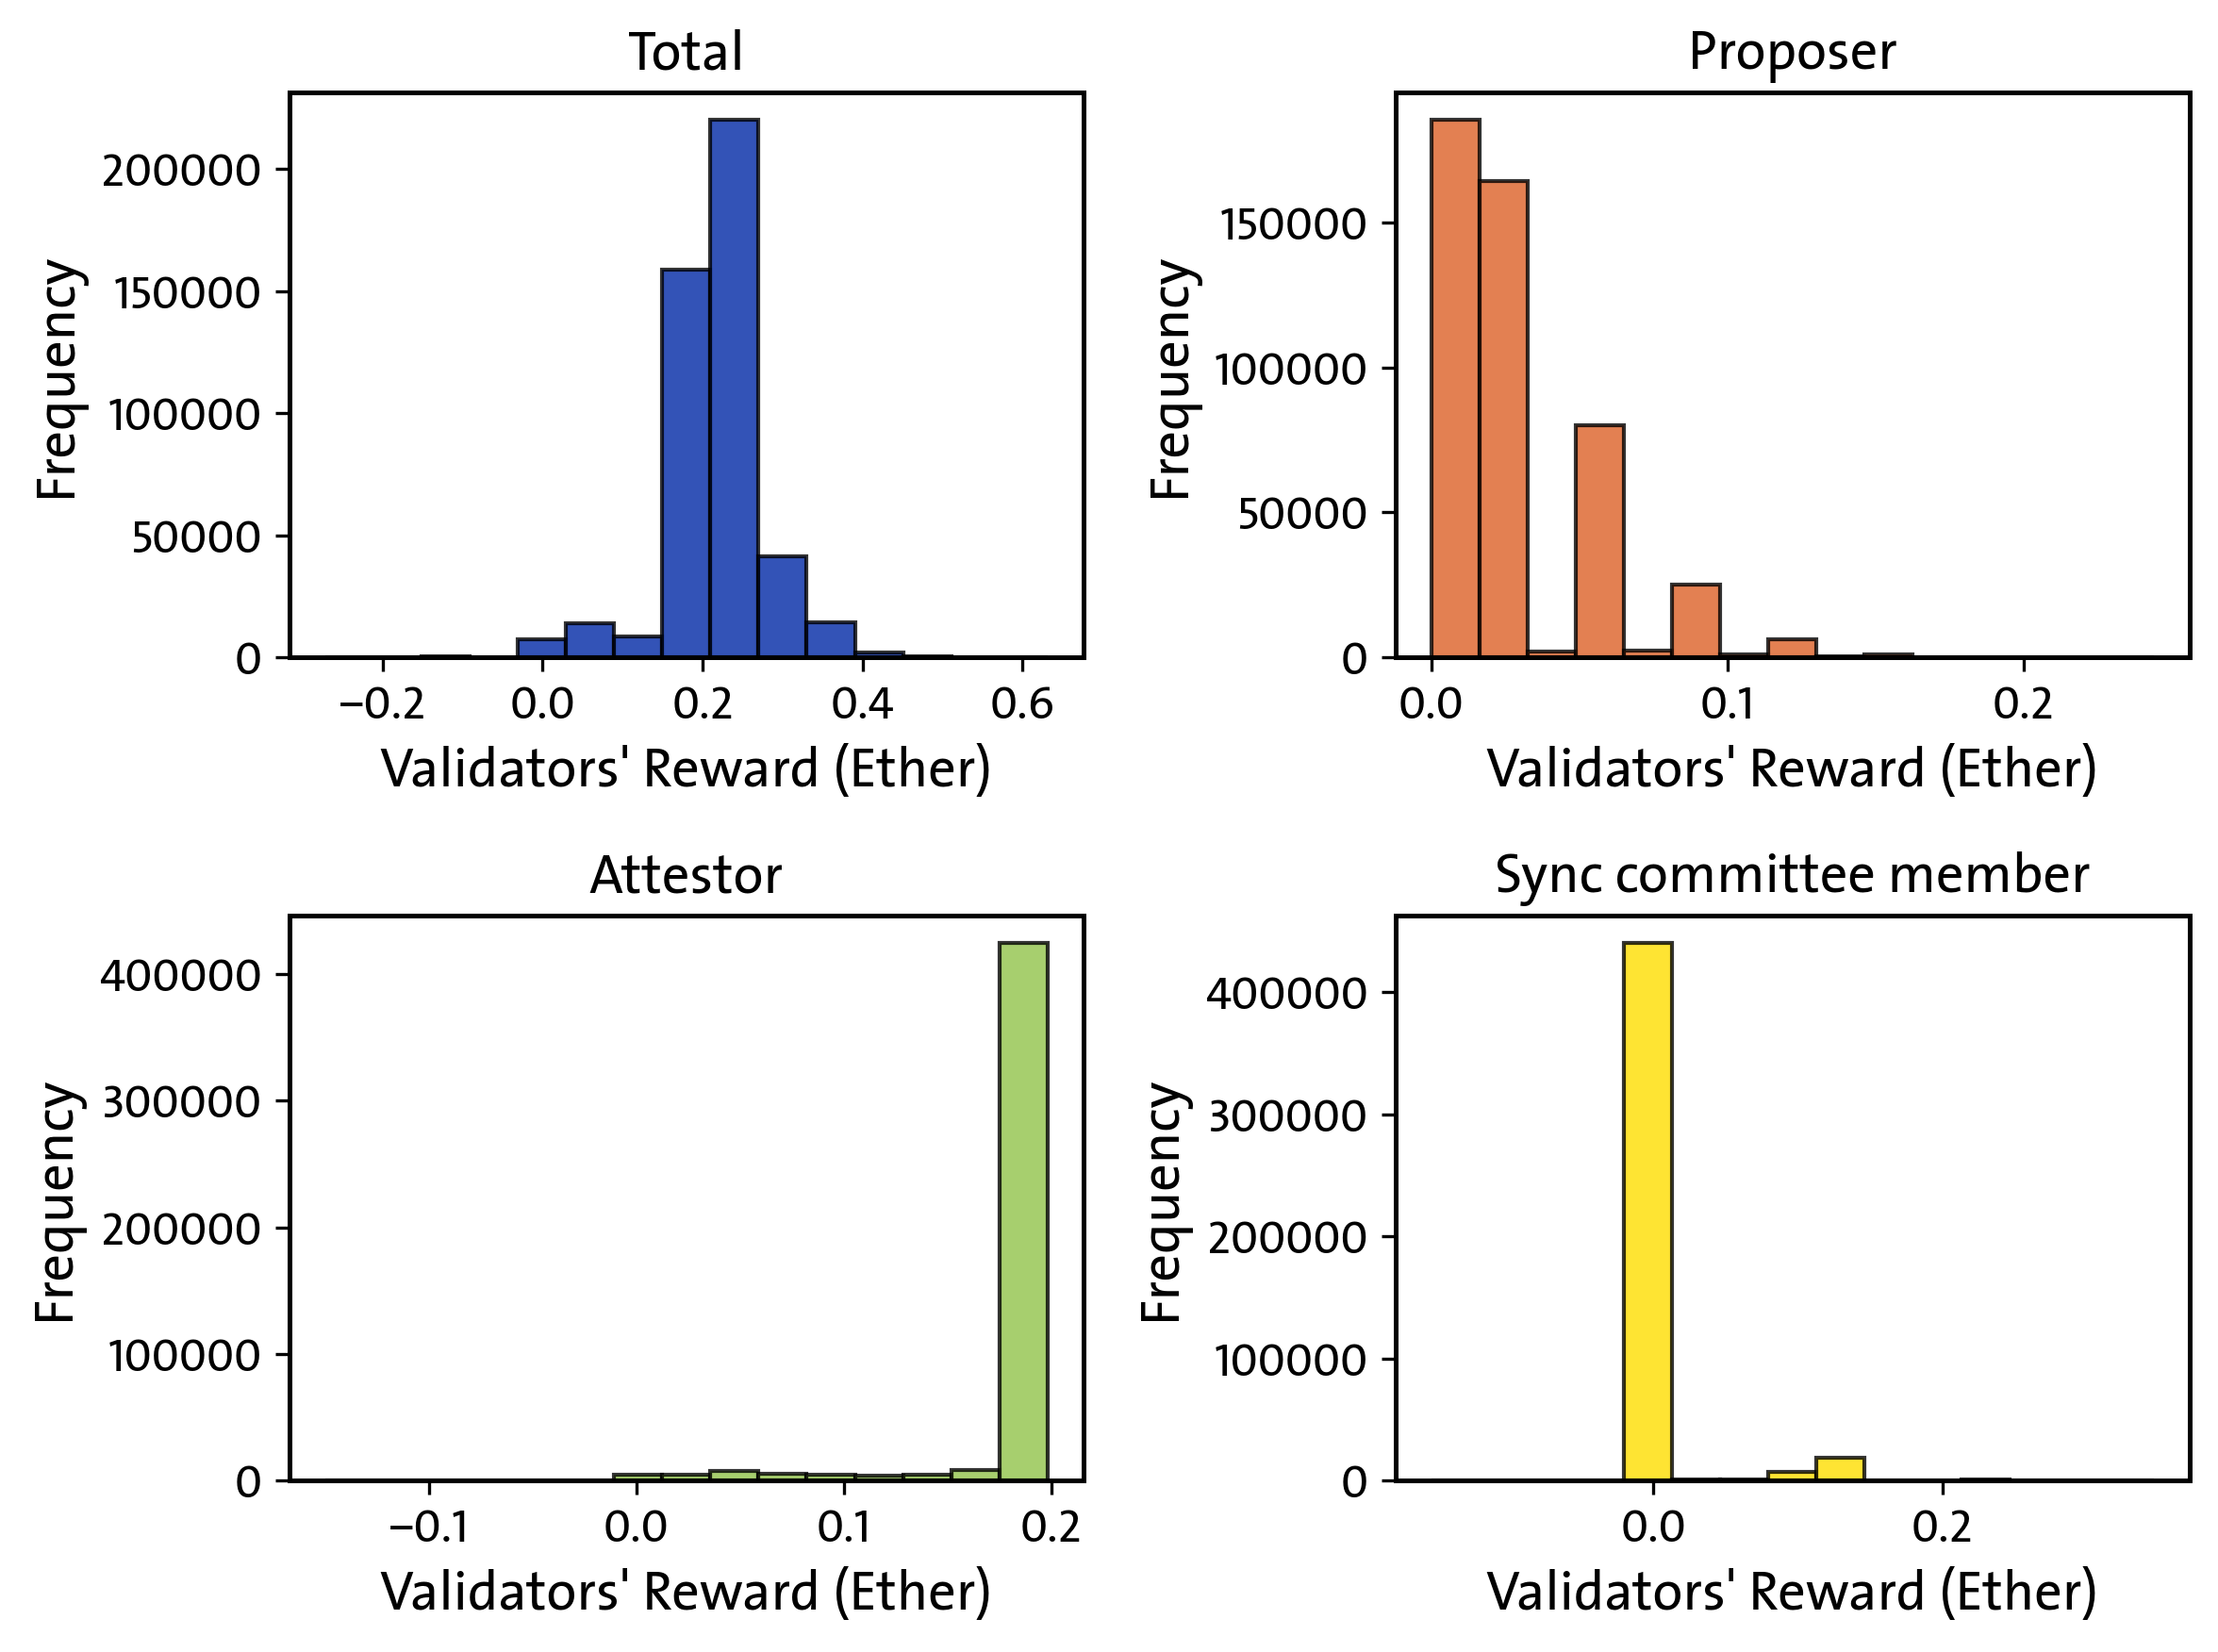

In [19]:
fig, axes = plt.subplots(2,2, figsize=(8, 6))
# Add histograms to each subplot column
labels=['Total','Proposer','Attestor','Sync committee member']
corlor=['#0028a5','#dc6027','#91c34a','#fede00']
for i,j in enumerate(validators_reward.columns[1:5], start=0):
    print(j)
    print(len(validators_reward))
    # if j in ['Proposer reward','Sync committee reward']:
        
    #     validators_reward1=validators_reward[validators_reward[j]!=0]
    #     axes[i//2][i%2].hist(validators_reward1[j], bins=15, alpha=0.8, label=labels[i], edgecolor='black',color=corlor[i])
    # else:
    #     axes[i//2][i%2].hist(validators_reward[j], bins=15, alpha=0.8, label=labels[i], edgecolor='black',color=corlor[i])
    axes[i//2][i%2].hist(validators_reward[j], bins=15, alpha=0.8, label=labels[i], edgecolor='black',color=corlor[i])
    axes[i//2][i%2].set_title(labels[i], fontsize=14)
    axes[i//2][i%2].set_xlabel("Validators' Reward (Ether)",fontsize=14)
    axes[i//2][i%2].set_ylabel('Frequency',fontsize=14)
    # axes[i//2][i%2].grid(zorder=100, lw =0.5)
    # axes[i//2][i%2].legend(fontsize=12)
    plt.tight_layout()
# plt.savefig('../figure/reward6_distribution_daily_validator.pdf',bbox_inches='tight',dpi=300,facecolor='white')

## Decompose the reward components of top 10 validators

In [20]:
top10_validators=validators_reward.sort_values(by='Total reward',ascending=False).head(10)['validator_index'].tolist()
top10_validators

[283345, 183569, 96482, 31988, 313675, 159285, 103193, 245107, 177529, 340118]

In [21]:
top10_validator_reward=validators_reward.sort_values(by='Total reward',ascending=False).head(10)
top10_validator_reward

,validator_index,Total reward,Proposer reward,Attestation reward,Sync committee reward
282499,283345,0.630899,0.089832,0.197475,0.343592
182829,183569,0.626627,0.089006,0.193916,0.343705
96209,96482,0.601686,0.060260,0.197428,0.343998
31832,31988,0.601638,0.058339,0.197383,0.345916
312827,313675,0.594269,0.167370,0.197084,0.229815
158549,159285,0.593131,0.059039,0.196517,0.337576
102686,103193,0.580725,0.149761,0.197211,0.233753
244263,245107,0.578051,0.146828,0.197560,0.233664
176789,177529,0.570818,0.030240,0.197618,0.342960
339270,340118,0.568887,0.145743,0.197097,0.226048


In [22]:
top10_validator_reward.set_index('validator_index', inplace=True)


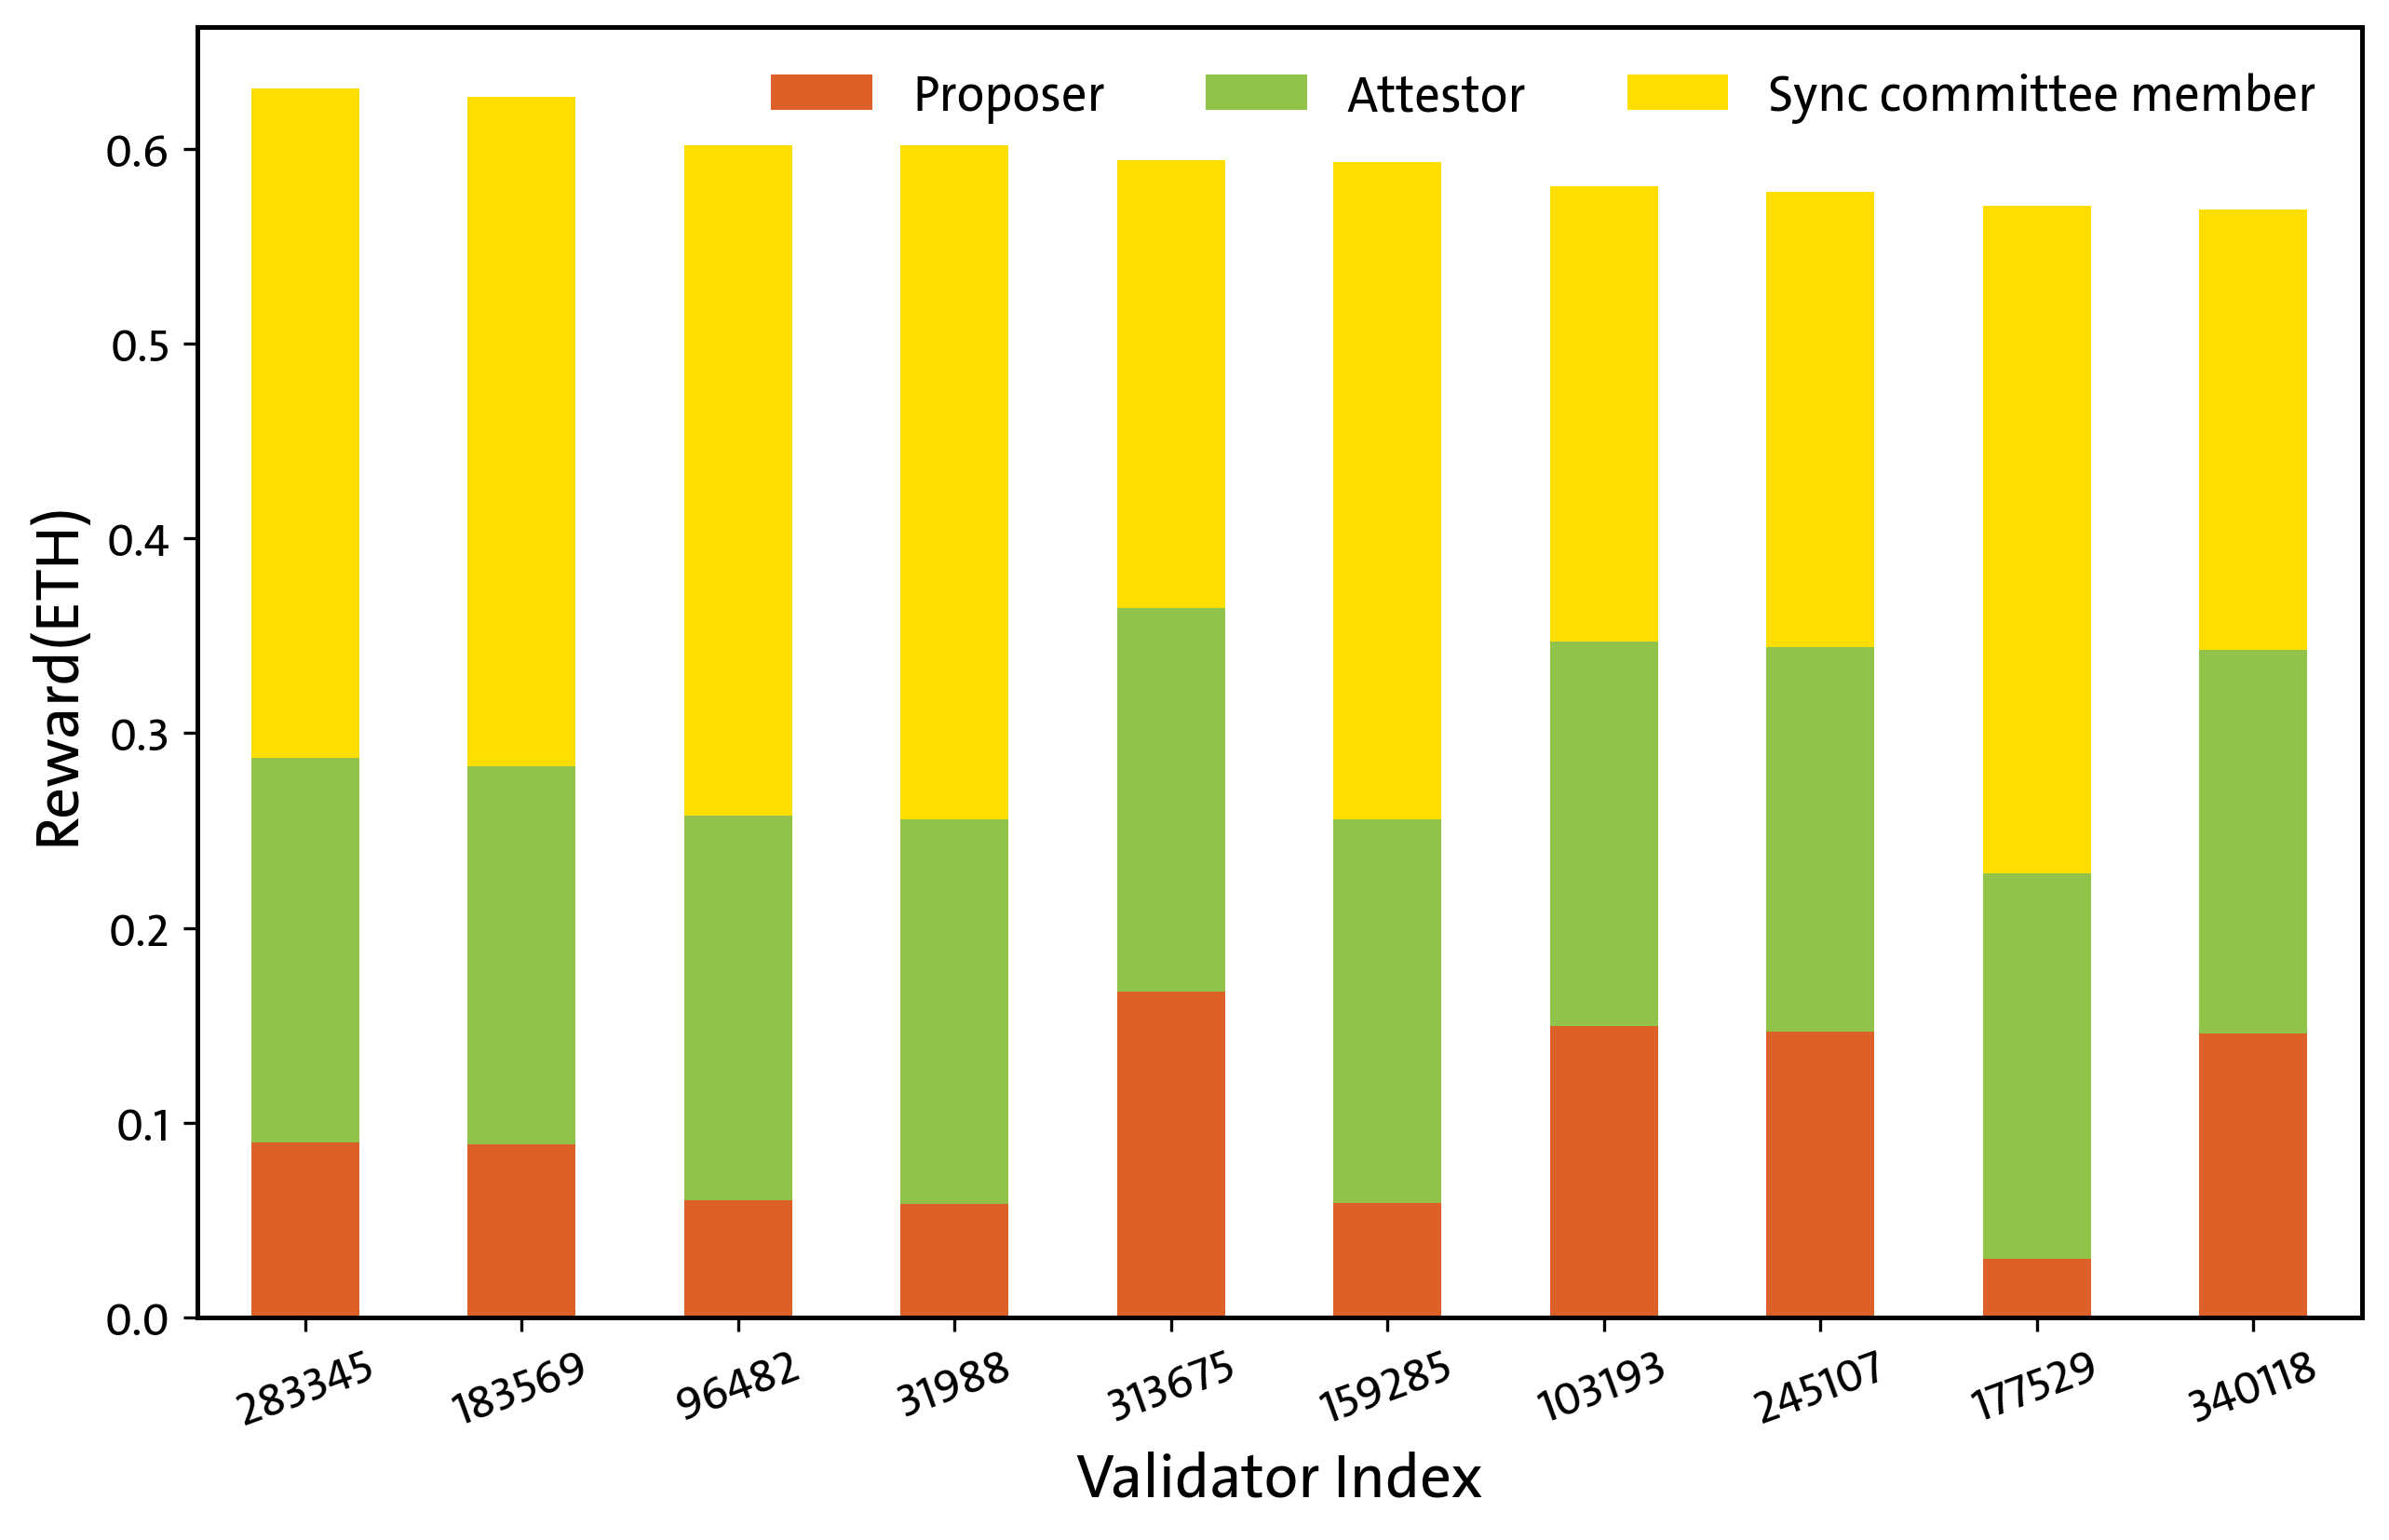

In [23]:
#a stacked bar chart to display the distribution of rewards among different validators.
top10_validator_reward1=top10_validator_reward[['Proposer reward','Attestation reward','Sync committee reward']]
top10_validator_reward1.rename(columns={'Proposer reward':'Proposer','Attestation reward':'Attestor','Sync committee reward':'Sync committee member'},inplace=True)
ax = top10_validator_reward1.plot(kind='bar', stacked=True, figsize=(10, 6),color=['#dc6027','#91c34a','#fede00'])
ax.legend(ncol=3,fontsize=13,frameon=False)
ax.set_xlabel('Validator Index')
ax.set_ylabel('Reward(ETH)')
ax.tick_params(axis='x', rotation=20)
# ax.set_title('Stacked Bar Chart for Rewards by Validator Index')
# plt.savefig('../reward7_stacked_bar_daily_validator.pdf',bbox_inches='tight',dpi=300,facecolor='white')


Surprisingly, sync committed reward has the largest share.

### The daily total reward of the top 10 validators.

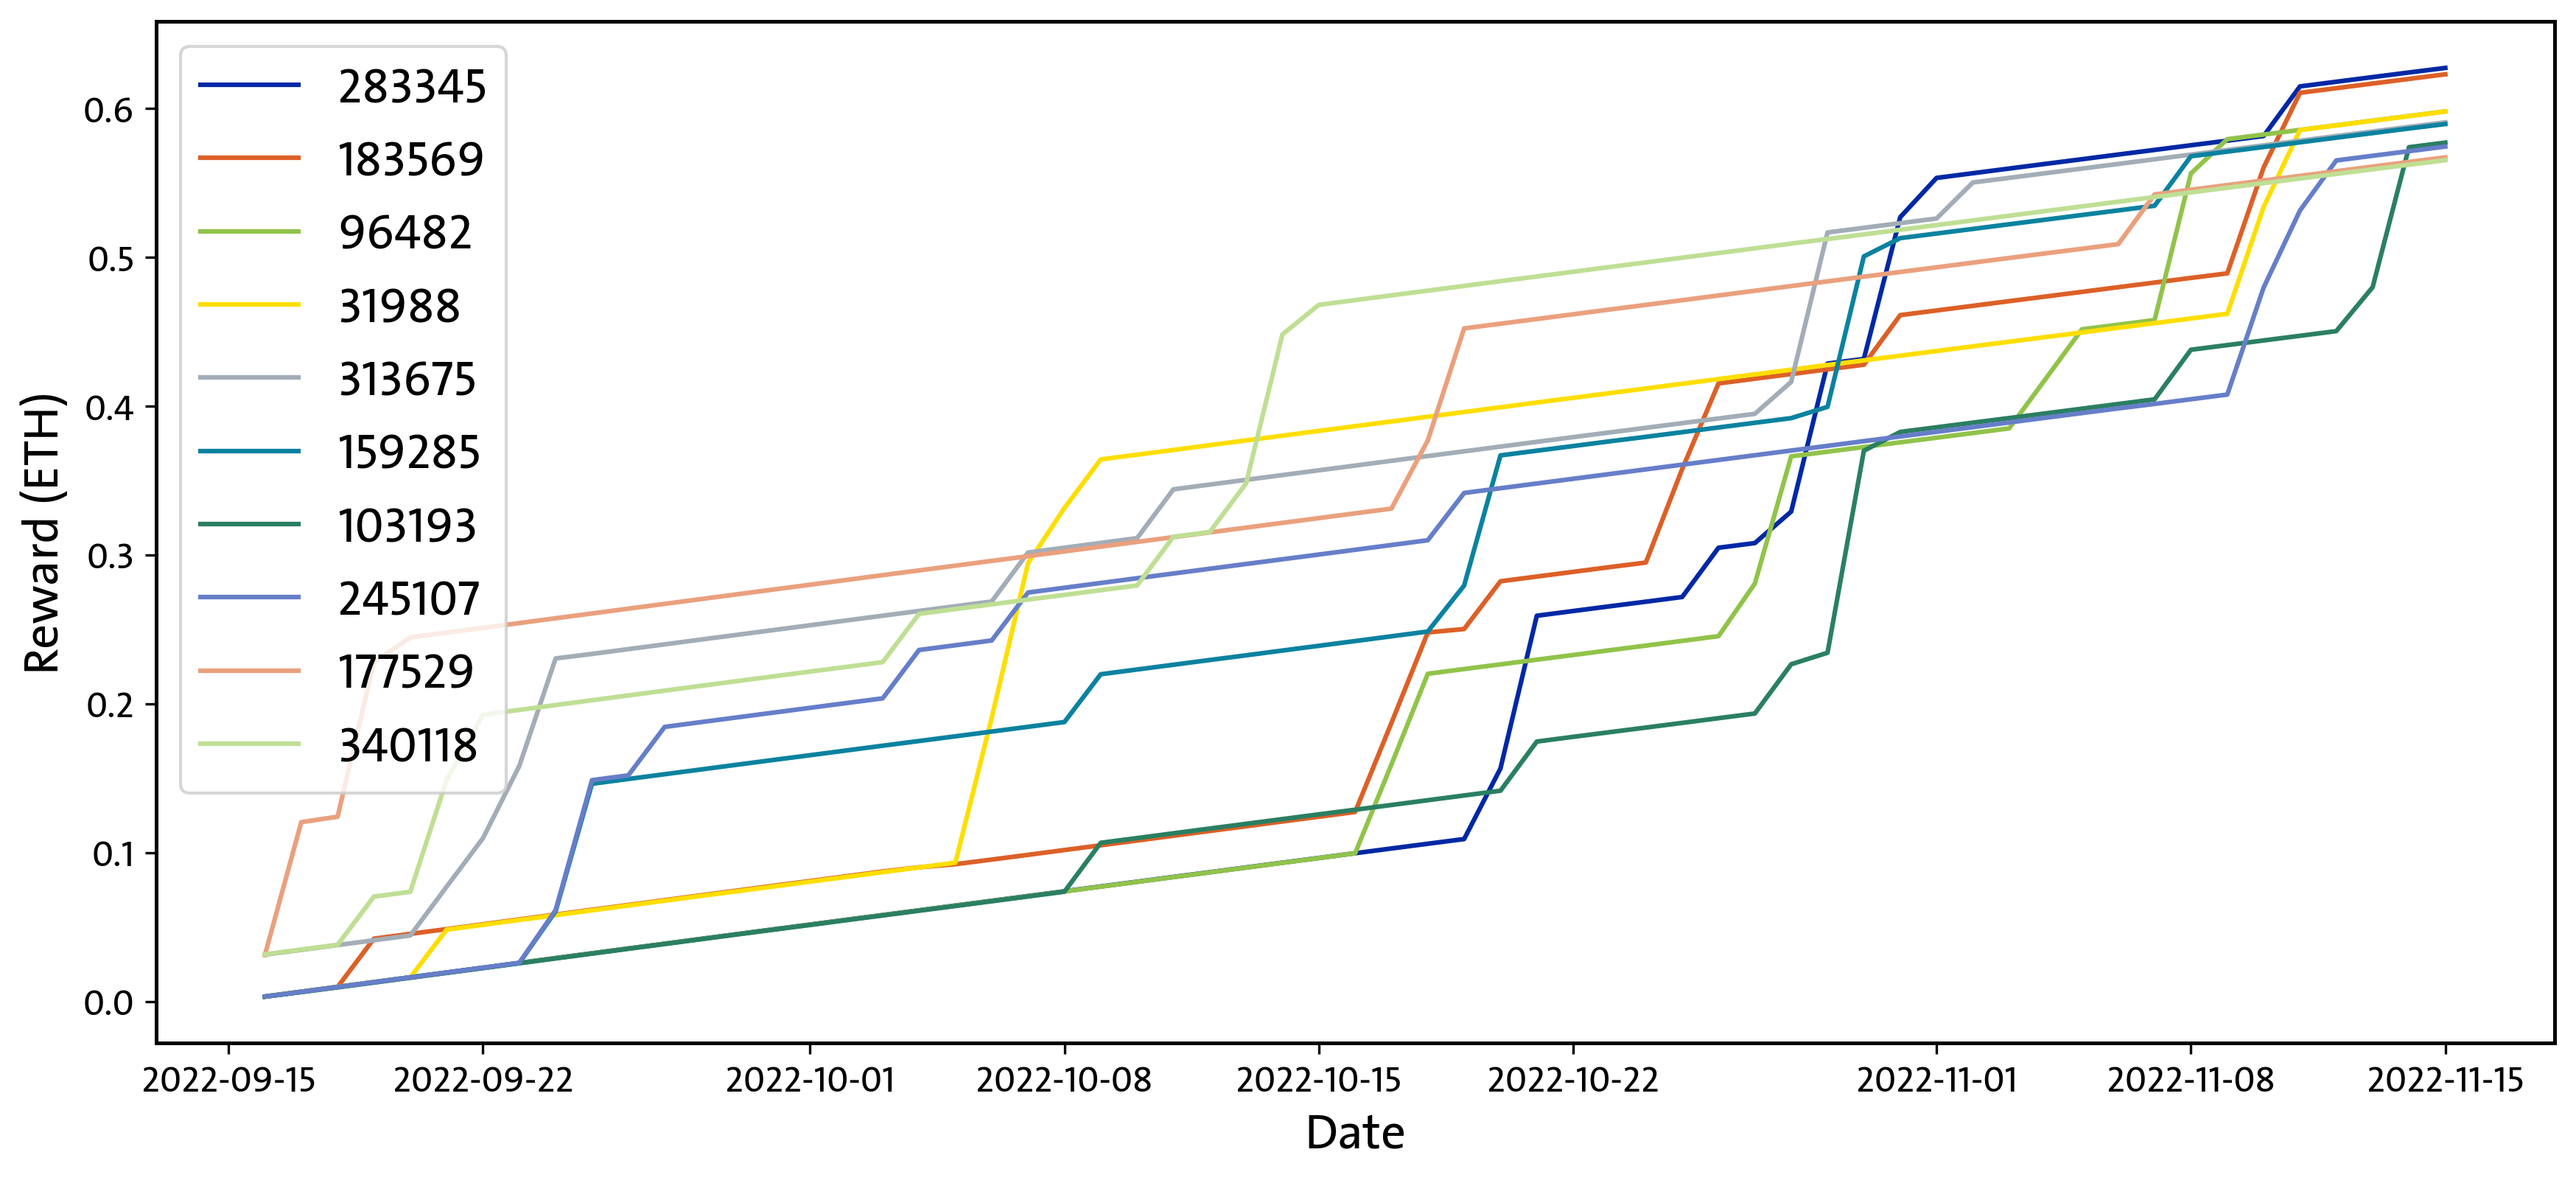

In [27]:
validator_daily_reward=df.groupby(['validator_index','date'])[['Total reward','Proposer reward','Attestation reward','Sync committee reward']].sum().reset_index()
#计算validator_daily_reward中每种 reward 的累计和
validator_daily_reward['Accumulative total reward']=validator_daily_reward.groupby('validator_index')['Total reward'].cumsum()
validator_daily_reward['Accumulative proposer reward']=validator_daily_reward.groupby('validator_index')['Proposer reward'].cumsum()
validator_daily_reward['Accumulative attestation reward']=validator_daily_reward.groupby('validator_index')['Attestation reward'].cumsum()
validator_daily_reward['Accumulative sync committee reward']=validator_daily_reward.groupby('validator_index')['Sync committee reward'].cumsum()
fig,ax=plt.subplots(figsize=(14,6),dpi=300)
validator_daily_reward['date']=pd.to_datetime(validator_daily_reward['date'])
for i in top10_validators:
    # validator_daily_reward[validator_daily_reward['validator_index']==i].plot(x='date',y='Accumulative total reward',ax=ax,label=i)
    ax.plot(validator_daily_reward[validator_daily_reward['validator_index']==i]['date'],validator_daily_reward[validator_daily_reward['validator_index']==i]['Accumulative total reward'],label=i,lw=1.5)
ax.set_xlabel('Date',fontsize=16)
ax.set_ylabel('Reward (ETH)',fontsize=16)
ax.legend(fontsize=16)
# plt.savefig('../reward7_daily_top_validator.pdf',bbox_inches='tight',dpi=300,facecolor='white')

## Accumculative rewards of validator 283345 over time

(19251.0, 19311.0)

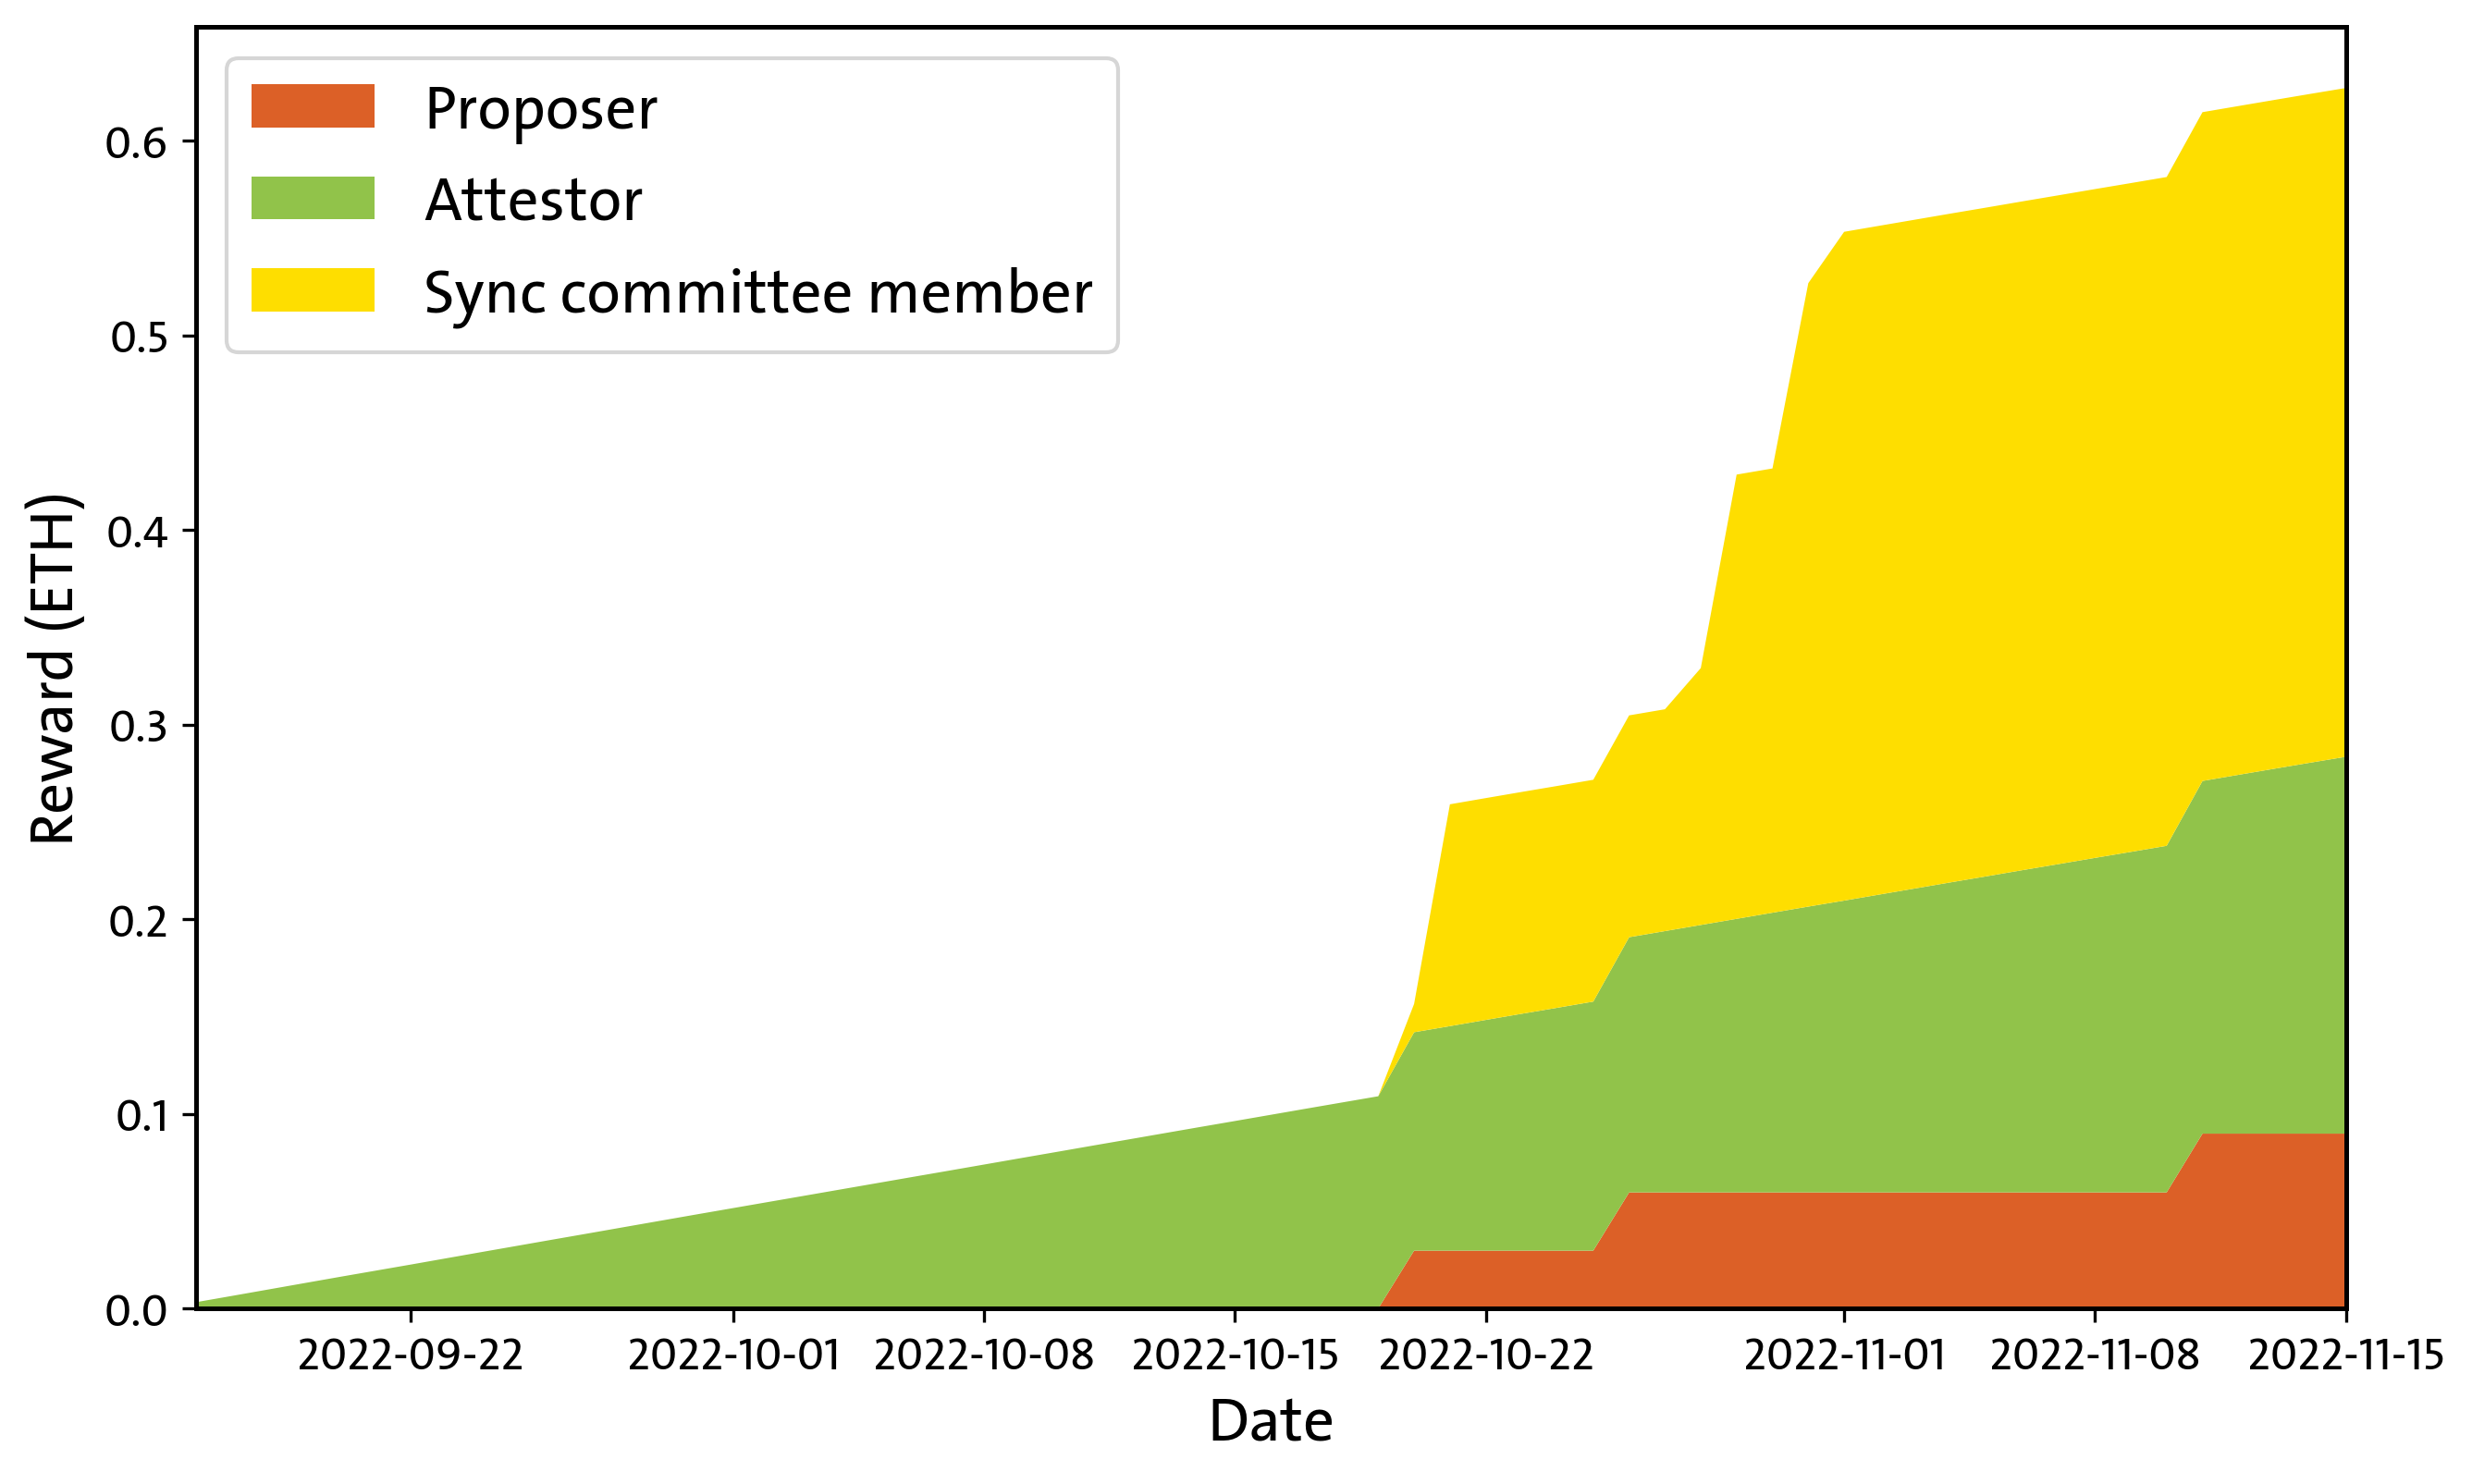

In [28]:
fig,ax=plt.subplots(figsize=(10,6),dpi=300)
validator_daily_reward['date']=pd.to_datetime(validator_daily_reward['date'])
for i in top10_validators[:1]:
    #画proposer,attestation, sync committee reward 的堆叠图
    ax.stackplot(validator_daily_reward[validator_daily_reward['validator_index']==i]['date'],validator_daily_reward[validator_daily_reward['validator_index']==i]['Accumulative proposer reward'],
                 validator_daily_reward[validator_daily_reward['validator_index']==i]['Accumulative attestation reward'],
                 validator_daily_reward[validator_daily_reward['validator_index']==i]['Accumulative sync committee reward'],
                 labels=['Proposer','Attestor','Sync committee member'],colors=['#dc6027','#91c34a','#fede00'])
ax.set_xlabel('Date',fontsize=16)   
ax.set_ylabel('Reward (ETH)',fontsize=16)
ax.legend(fontsize=16,loc='upper left')
ax.set_xlim(left=validator_daily_reward['date'].iloc[0])
ax.set_xlim(right=validator_daily_reward['date'].iloc[-1])
# plt.savefig('../reward8_daily_top_validator.pdf',bbox_inches='tight',dpi=300,facecolor='white')

In [38]:
df.shape

(27253258, 6)

In [6]:
df.groupby('date')[['validator_index']].count().reset_index().to_csv('./data/daily_validator_number_new.csv',index=False)

## valdator number and average reward of validators

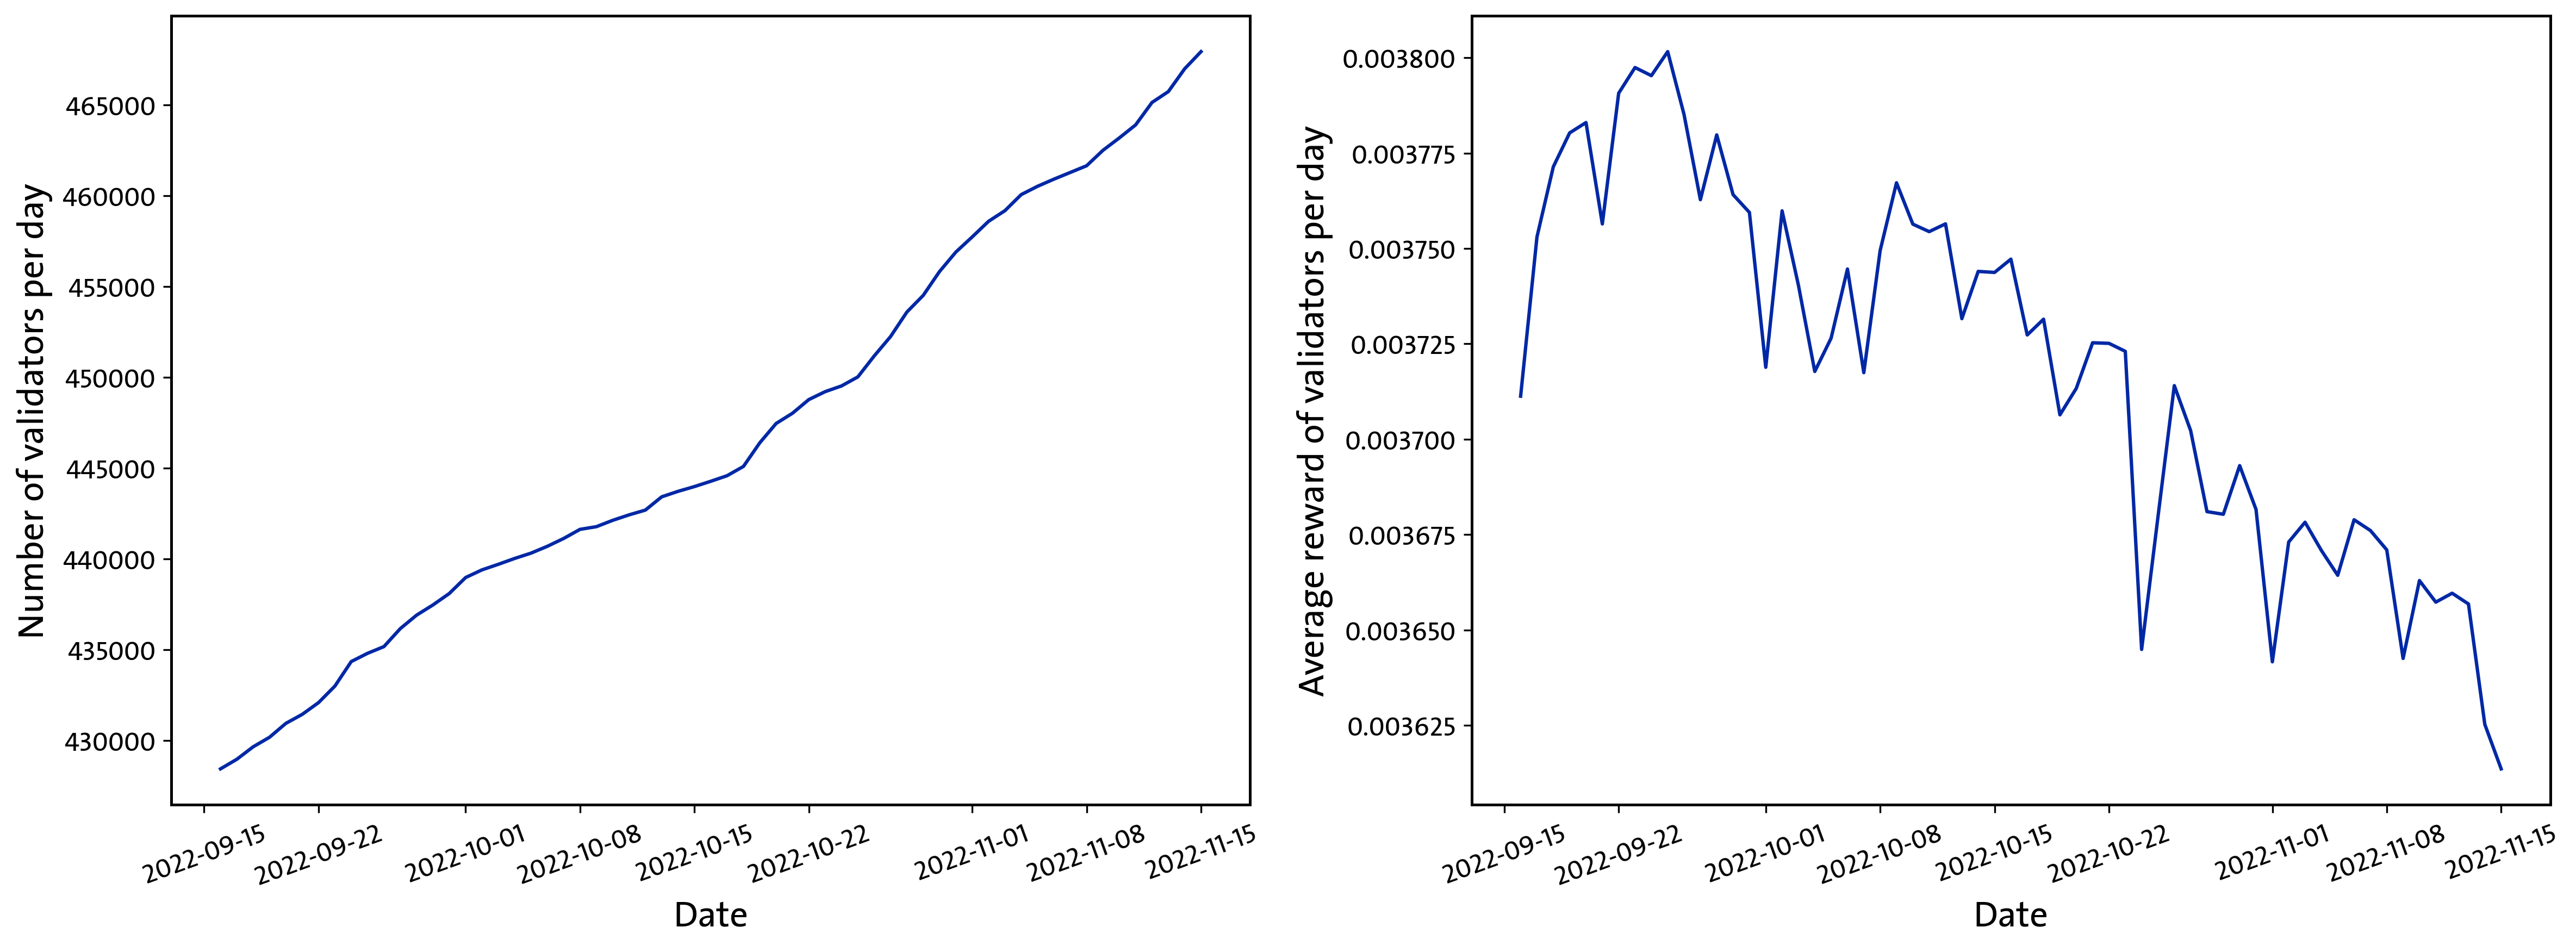

In [26]:
import matplotlib.pyplot as plt
df.rename(columns={'final_total_reward':'Total reward','proposer_total_reward':'Proposer reward','attestation_total_reward':'Attestation reward','sync_total_reward':'Sync committee reward'
                   },inplace=True)
df['date']=pd.to_datetime(df['date'])
df=df[(df['date']>=pd.to_datetime('2022-09-16'))&(df['date']<=pd.to_datetime('2022-11-15'))]
# Calculate the mean of Validator_index by Date
validator_counts = df.groupby('date')['validator_index'].nunique().reset_index()
validator_means = df.groupby('date')['Total reward'].mean().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Add line plot to the first subplot
axs[0].plot(validator_counts['date'], validator_counts['validator_index'],lw=1.5)
# axs[0].set_title('Validator Counts over time')
axs[0].set_ylabel('Number of validators per day',fontsize=16)
axs[0].set_xlabel('Date',fontsize=16)
axs[0].autoscale(enable=True, axis='x', tight=True)

axs[0].tick_params(axis='x', rotation=20)

# Add line plot to the second subplot
axs[1].plot(validator_means['date'], validator_means['Total reward'],lw=1.5)
# axs[1].set_title("Average Validator's Reward over Time")
axs[1].set_ylabel("Average reward of validators per day",fontsize=16)
axs[1].set_xlabel('Date',fontsize=16)

axs[1].tick_params(axis='x', rotation=20)

plt.tight_layout()

# plt.savefig('../figure/validator_count_reward_daily.pdf',bbox_inches='tight',dpi=300,facecolor='white')


In [29]:
data.shape #2022-09-15    2022-11-16

(40200209, 6)

In [31]:
df.shape# 2022-09-16-2022-11-15

(27253258, 6)

# Part II Index

> To calculate the Shanon entropy,HHI, Gini index and the Nakamoto coefficient of the distribution of the rewards among validators, we have two scripts:

>The first script(suggested): cd to the folder `scripts`, run the script in the terminal `calculate_index1_shanon_entropy.py`,
`calculate_index2_hhi.py`, 
`calculate_index3_gini_index.py` 
`calculate_index4_nakamoto_coefficient.py` 
  

>The second script: run the following cells  until `Gini index plot` cell.

In [32]:
def index(df):
    df['value'] = df['value'].astype(float)
    df['prop'] = df['value']/df['value'].sum() 
    H = -df['prop']*np.log2(df['prop'])
    E = H.sum()
    V = 2**E
    return V

def HHI(df):
    df['value'] = df['value'].astype(float)
    df['prop'] = df['value']/df['value'].sum() 
    SQ = df['prop']**2
    V = SQ.sum()
    return V

def gini(df):
    """
    Compute Gini coefficient of a DataFrame with a 'value' column
    """
    # Check if the DataFrame is empty or the 'value' column does not exist
    if df.empty or 'value' not in df.columns:
        return None 
    # Extract the 'value' column and convert it to a sorted list
    values = sorted(df['value'].tolist())
    # Check if the list is empty
    if len(values) == 0:
        return None
    # Compute the cumulative sum of the values
    cum_values = [0] + list(pd.Series(values).cumsum())
    n = len(values)
    # Calculate Gini coefficient using the formula
    numer = sum([(i+1) * values[i] for i in range(n)])
    denom = n * sum(values)
    if denom == 0:
        return None  # Avoid division by zero
    gini = (2 * numer) / denom - (n + 1) / n
    return gini

def nakamoto(df,validator_number):
    df['value'] = df['value'].astype(float)
    df.sort_values(by=['value'],ascending=False,inplace=True)
    df.reset_index(inplace=True,drop=True)
    df.set_index(keys=df.index.values+1,inplace=True)
    df['prop'] = df['value']/df['value'].sum() 
    df['cumprop'] = df['prop'].cumsum(axis=0)
    try:
        V = df[df['cumprop'] > 0.5].index[0]
        return V/validator_number
    except:
        return 0


In [33]:
from datetime import date
start = date(2022,9,15)
end = date(2022,11,15)

In [34]:
"""
def index_calc(data):

            :param data: dataframe containing transaction value and timestamp of the transaction (block_timestamp)
            :type data: pandas.DataFrame object
            :param start: the start date of calculation 00:00:00 UTC
            :type start: datetime.date object
            :param end: the end date of calculation 23:59:59 UTC
            :type end: datetime.date object
            :param index_type: the metrics used for measuring decentralization, default is our index
            :type index_type: index function

    returns pandas dataframe with decentralization index value and date
"""
from tqdm import tqdm
def index_calc(data, start, end, index_type = index):
    duration= pd.date_range(start=start, end=end)
    days = np.size(duration)
    IndexValues = pd.DataFrame(np.zeros(days), columns=['val'])
    IndexValues['date'] = duration

    for i in tqdm(range(0, days)):
        start_date = start + timedelta(days=i)
        end_date = start_date + timedelta(days=1)
        IndexValues.loc[i,'val'] = index_type(data[(data['Date'].dt.date > start_date) & (data['Date'].dt.date < end_date)].copy())
    return IndexValues
    

In [37]:
data.sort_values(by=['date'],ascending=True,inplace=True)

In [59]:
data.head(5)

,Date,Validator_index,final_total_sum,proposer_total_reward,attestation_total_reward,sync_total_reward
4902107,2022-09-15,107242,2282269,0,2282269,0
4938035,2022-09-15,143174,2311335,0,2311335,0
4938036,2022-09-15,143175,2336083,0,2336083,0
4938037,2022-09-15,143176,2339536,0,2339536,0
4938038,2022-09-15,143177,2285473,0,2285473,0


## shanon entropy of validator's reward

In [139]:
#input transaction data and desired date range
#returns index value 1 if specification range exceeds data 
start = date(2022,9,15)
end = date(2022,11,16)
results = index_calc(data,start,end)

  0%|          | 0/63 [00:00<?, ?it/s]

In [123]:
results

,val,date
0,343355.884109,2022-09-15
1,351274.247678,2022-09-16
2,648974.785487,2022-09-17
3,342529.276095,2022-09-18
4,585185.586917,2022-09-19
...,...,...
57,365539.214555,2022-11-11
58,440961.830361,2022-11-12
59,366709.081461,2022-11-13
60,623858.251846,2022-11-14


In [28]:
results.to_csv('ShannonIndex.csv',index=False)

## HHI of validator's reward

In [29]:
#specify alternate index metric: HHI
#returns index value 0 if specification range exceeds data
start = date(2022,9,15)
end = date(2022,11,15)
results_HHI = index_calc(data,start,end,HHI)
results_HHI.to_csv('HHI_Index.csv',index=False)

100%|██████████| 62/62 [09:04<00:00,  8.78s/it]


In [31]:
results_HHI

,val,date
0,0.000007,2022-09-15
1,0.000006,2022-09-16
2,0.000006,2022-09-17
3,0.000007,2022-09-18
4,0.000007,2022-09-19
...,...,...
57,0.000005,2022-11-11
58,0.000005,2022-11-12
59,0.000006,2022-11-13
60,0.000006,2022-11-14


## GINI index of validator's reward

In [67]:
#specify alternate index metric: gini
#returns index value 0 if specification range exceeds data
start = date(2022,9,15)
end = date(2022,11,15)
results_Gini = index_calc(data,start,end,gini)
results_Gini.to_csv('Gini_Index.csv',index=False)

100%|██████████| 62/62 [09:38<00:00,  9.33s/it]


## Nakamoto coefficient of validator's reward

In [ ]:
start = date(2022,9,15)
end = date(2022,11,15)
results_Nakamoto = index_calc(data,start,end,nakamoto)
results_Nakamoto.to_csv('Nakamoto_Index.csv',index=False)

## index plot

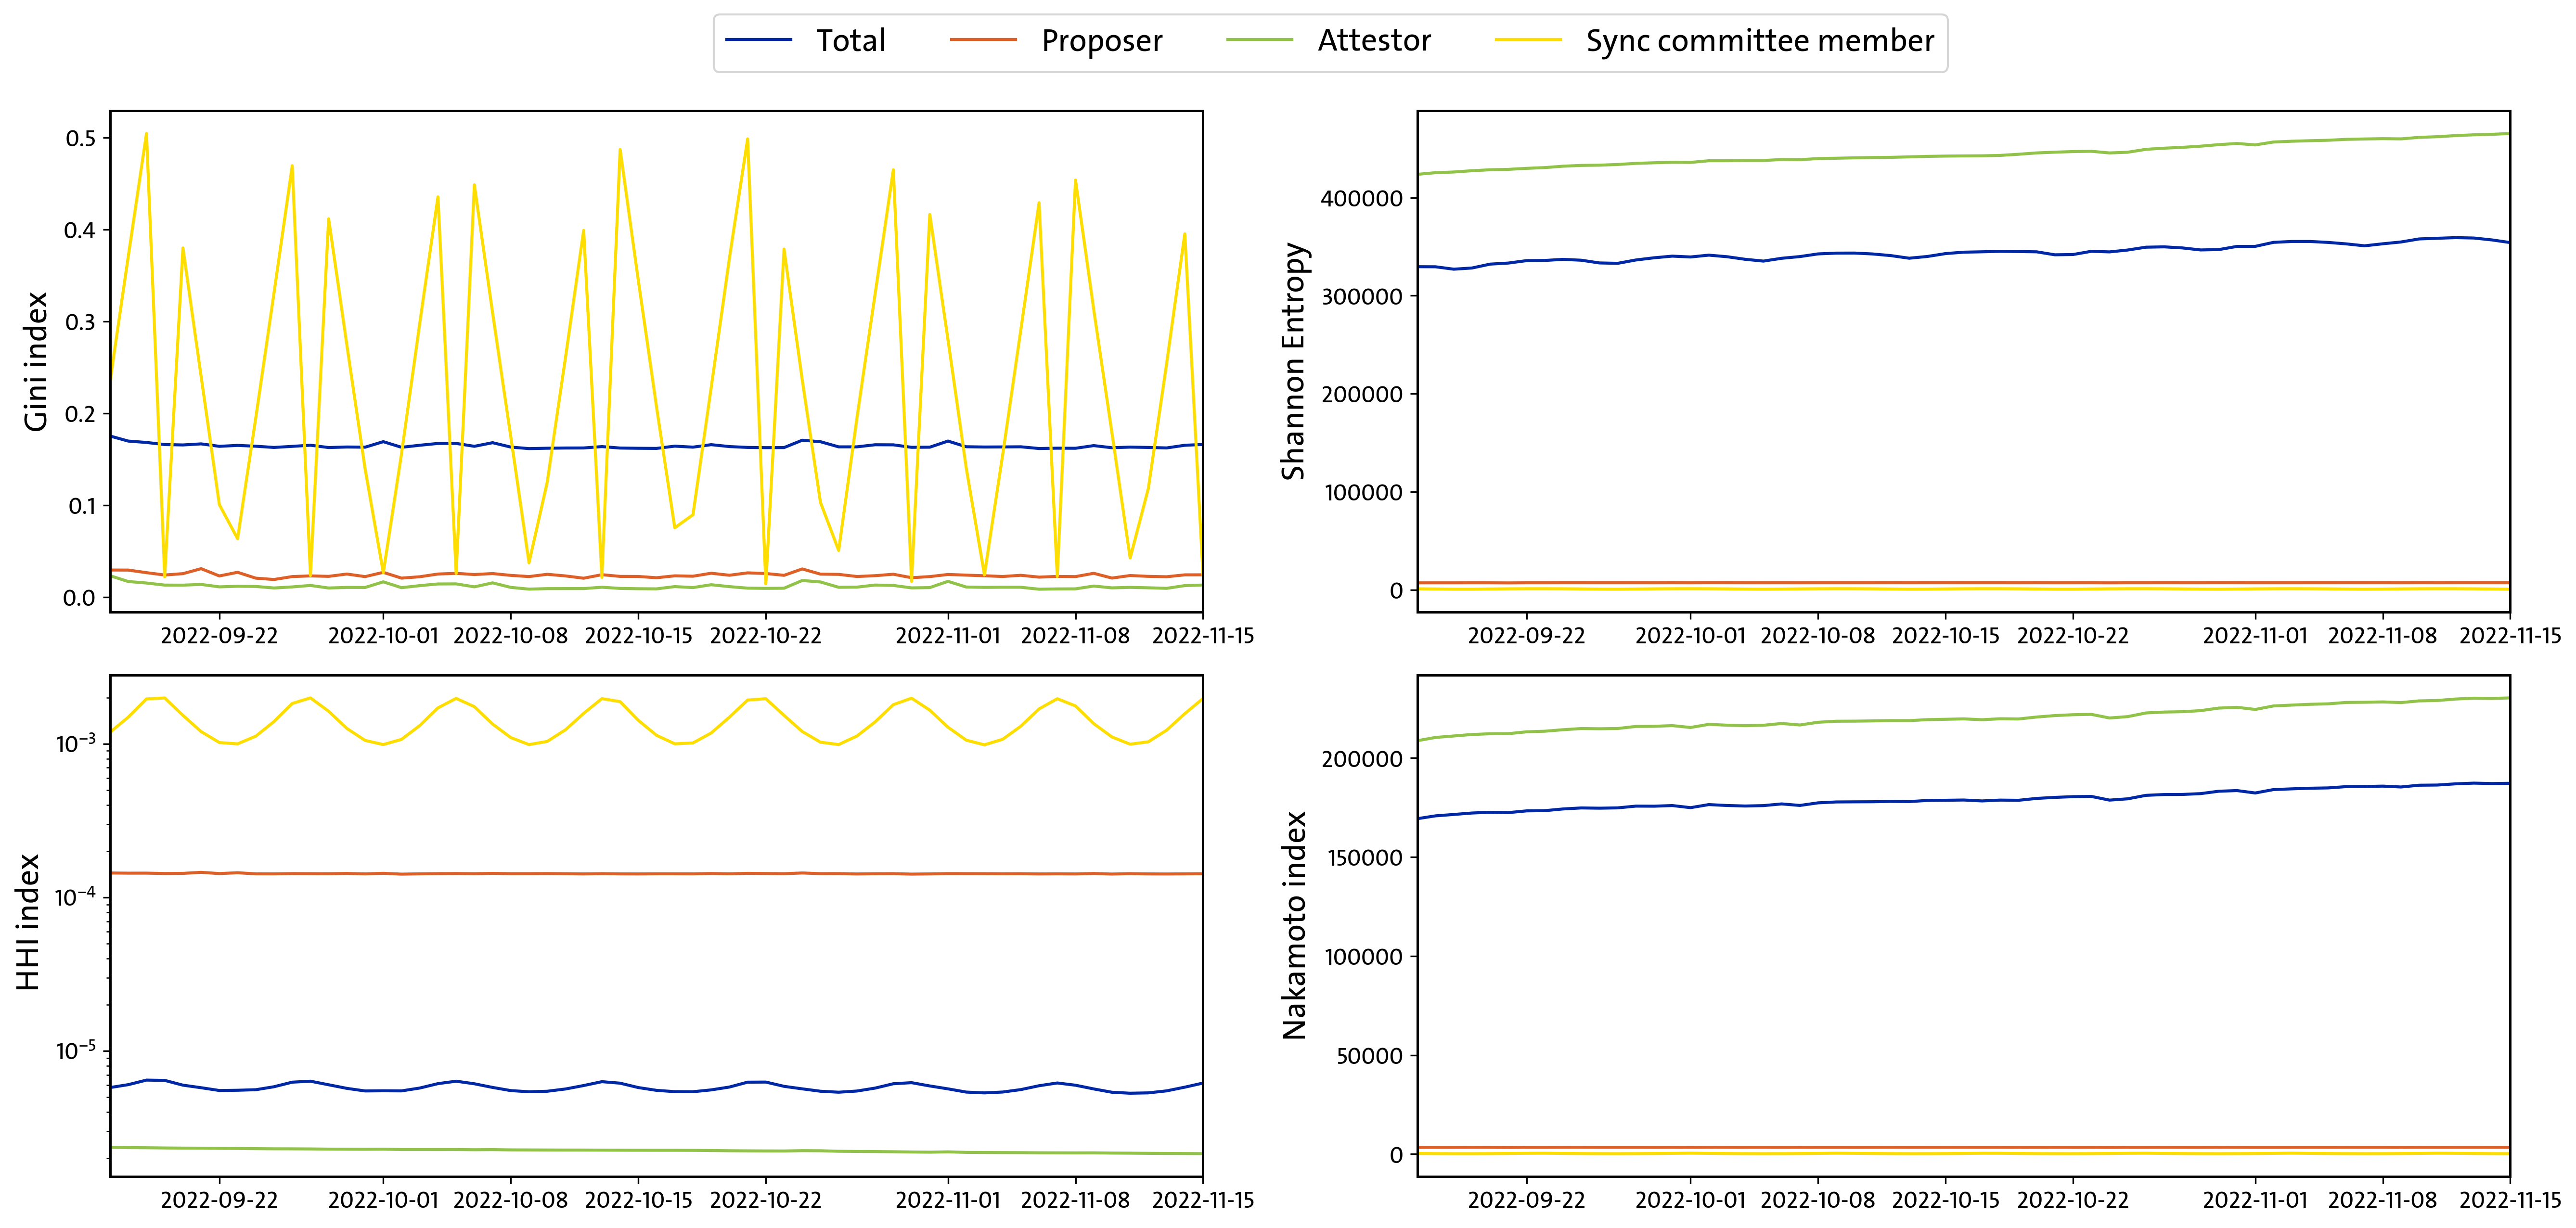

In [40]:
from glob import glob
files=glob('/home/user/yan/github/ETH2.0-reward/data/index_data_3/*.csv')
validator_counts =pd.read_csv('/home/user/yan/github/ETH2.0-reward/data/daily_validator_number_new.csv')
# 2*2 subplots
fig,axes=plt.subplots(2,2,figsize=(18,8),dpi=300)
for file in files:
    index=pd.read_csv(file)
    index['date']=pd.to_datetime(index['date'])
    index_name=file.split('/')[-1].split('.')[0].split('_')[0]
    index_name=index_name[0].upper()+index_name[1:]
    reward_type=file.split('/')[-1].split('.')[0].split('_')[1]
    # reward_type=['Total','Proposer','Attestor','Sync committee member']
    if index_name=='Gini':
        axes[0,0].plot(index['date'],index[reward_type],label=reward_type)
        #set the y-axis label
        axes[0,0].set_ylabel(f'{index_name} index',fontsize=16)
        #use percentage for y-axis
        # axes[0,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        # axes[0,0].legend(fontsize=16,ncol=2)
        axes[0,0].autoscale(enable=True, axis='x', tight=True)
        axes[0,0].set_xlim(left=pd.to_datetime('2022-09-16'))
        # axes[0,0].set_yscale('log') 
    if index_name=='Index':
        axes[0,1].plot(index['date'],index[reward_type],label=reward_type)
        axes[0,1].set_ylabel(f'Shannon Entropy',fontsize=16)
        #use percentage for y-axis
        # axes[0,1].legend(fontsize=16,ncol=2)
        axes[0,1].autoscale(enable=True, axis='x', tight=True)
        axes[0,1].set_xlim(left=pd.to_datetime('2022-09-16'))
    
    if index_name=='HHI':
        # reviese_HHI=index[reward_type]* validator_counts['validator_index'][1:].values
        axes[1,0].plot(index['date'],index[reward_type],label=reward_type)
        # axes[1,0].plot(index['date'],reviese_HHI,label=reward_type)
        axes[1,0].set_ylabel(f' HHI index',fontsize=16)
        #use percentage for y-axis
        axes[1,0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
        # axes[1,0].legend(fontsize=16,ncol=2)
        axes[1,0].autoscale(enable=True, axis='x', tight=True)
        axes[1,0].set_xlim(left=pd.to_datetime('2022-09-16'))
        axes[1,0].set_yscale('log')
        
    if index_name=='Nakamoto':
        axes[1,1].plot(index['date'],index[reward_type],label=reward_type)
        axes[1,1].set_ylabel(f'{index_name} index',fontsize=16)
        #use percentage for y-axis
        # axes[1,1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
        # axes[1,1].legend(fontsize=16,ncol=2)
        axes[1,1].autoscale(enable=True, axis='x', tight=True)
        axes[1,1].set_xlim(left=pd.to_datetime('2022-09-16'))
plt.tight_layout()
#rename the legend
handles, labels = axes[0,0].get_legend_handles_labels()
labels[0]='Total'
labels[1]='Proposer'
labels[2]='Attestor'
labels[3]='Sync committee member'
#set the legend location
plt.legend(handles,labels,fontsize=16,ncol=4,bbox_to_anchor=(0.5,2.35),frameon=True)
# plt.savefig('../figure/4_index_timeseries.pdf',bbox_inches='tight',dpi=300,facecolor='white')



# References:
Code adapted from SoK: Blockchain Decentralization: https://arxiv.org/abs/2205.04256